## Océrisation du Carmen de martyrio Maccabaeorum

### Installation des librairies

In [2]:
%%capture capt
#On utilise Pytesseract qui lui-même utilise Tesseract, outil d'océrisation de Google.
!pip install pytesseract
#On utilise OpenCV pour manipuler aisément les images.
!pip install opencv-python

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract

In [ ]:
#On indique à Pytesseract où se situe l'exécutable Tesseract, préalablement installé sur notre machine.
pytesseract.pytesseract.tesseract_cmd = r'D:\Tesseract2\tesseract.exe'
#On affiche toutes les langues disponibles : Tesseract est notamment capable de traiter l'ancien français et le latin
print(pytesseract.get_languages(config=''))

### Essai de preprocessing

In [16]:
#Mettre l'image en gris :
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Enlever le bruit tant que possible :
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#Ne garder que les pixels au-delà d'un certain seuil (= d'une certaine teinte de gris) :
def thresholding(image,adaptative,OTSU):
    #Nous fournissons deux autres variables :
    #La première mise à TRUE réalise un seuillage adaptatif
    #La seconde mise à TRUE et la première mise à FALSE réalise un seuillage de type OTSU
    #Si les deux sont mises à FALSE, on réalise un seuillage fixe
    #Les valeurs chiffrées correspondent à la fenêtre des valeurs retenues du pixel. 
    if OTSU:
        (T, threshInv) = cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        print(T)
        return threshInv
    if adaptative:
        return cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,4)
    else:
        (T, threshInv) = cv2.threshold(image, 140, 255,cv2.THRESH_BINARY_INV)
        print(T)
        return threshInv
    
#Dilatation de l'image
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#Erosion de l'image
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#Erosion + dilatation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#Détection de type CANNY
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#Comparaison avec un Template
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

### Preprocessing avec une page témoin du Carmen

In [19]:
#On ouvre notre image
img = cv2.imread('./CdMM/Photos/1.jpg')

#On affiche le texte
print(pytesseract.image_to_string(img, lang='lat'))

HILARII DE MARTYRIO MACCABAEORYM,

Maccab. II lex. fuit. Antiochus Syriae ditissimus olim.

6 et 7 jn cuius regno mater natique fuerunt
septem, ut fama refert, de sancta gente creati.
quos cura adsidue generis meminisse iubebat

9 et legi seruire datae: sic namque uolentes
de populo meliore dei sua iura tenebant.
rex auidus mutare fidem, mutare timorem
iustorum uoluit. populo ut misceret iniquo.
praemia promittit matri, promittit et auri,

10 et quidquid posset toto conquirere regno,
si modo mutaret mores sensusque priores,
eogeret et natos alios sibi fingere mores.
illa negat tacitumque premit sub corde dolorem.
hane postquam nulla potuit conpellere praeda,

15 temptauit primum tormentis uincere saeuis;
pertulit illa graues gemitus et tristia regis
uerbera non timuit. uictum ut se uidit at ille:
.Heu. quid agam,* dixit, ,uincis quod femina regem ?
non tamen effugies: plus est, quod dura dolebis.

INCIPIT HYLARII DE MARTYRIO MACHABEORVM P (Paris 2772)
Incipiunt uersus hilarii in natale

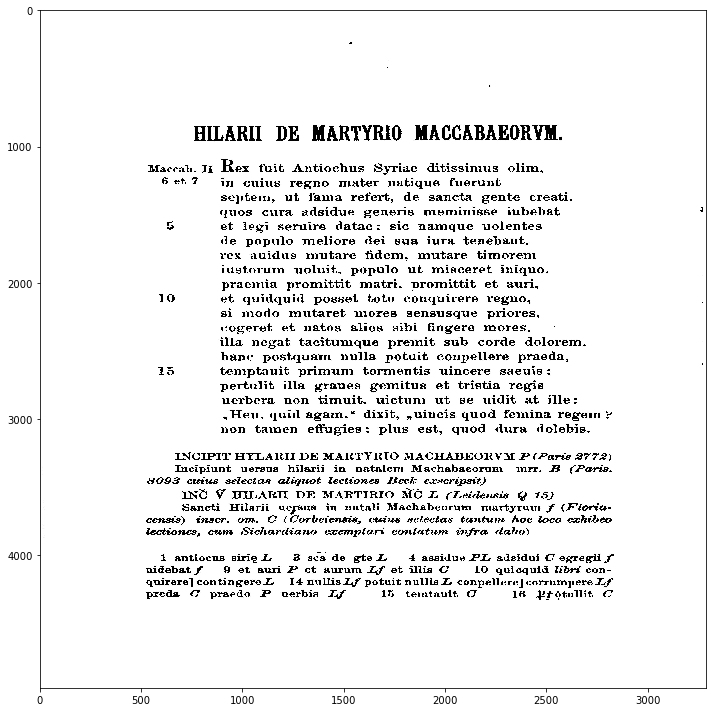

In [14]:
#On ouvre notre image brute
img = cv2.imread('./CdMM/Photos/1.jpg')
#On l'affiche
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, interpolation='nearest', aspect='auto',cmap='Greys')
plt.tight_layout()

38.0


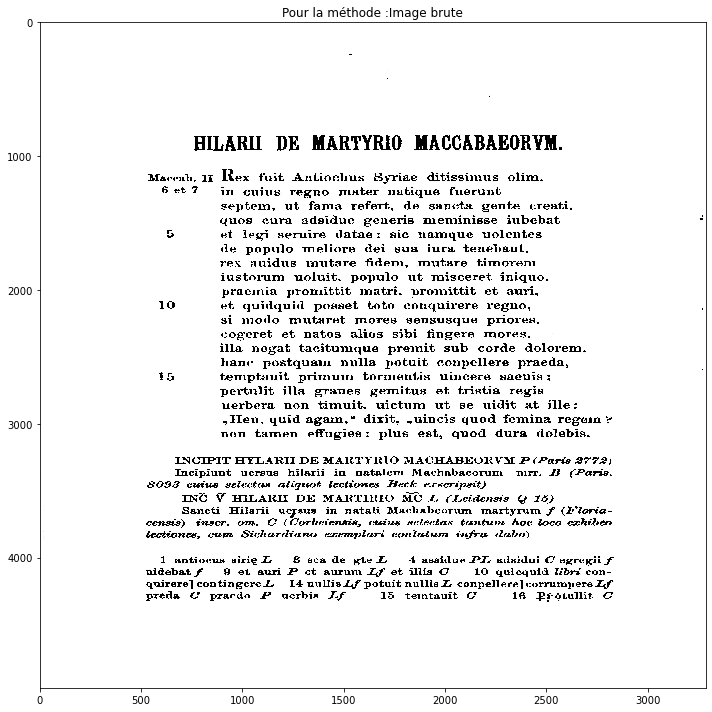

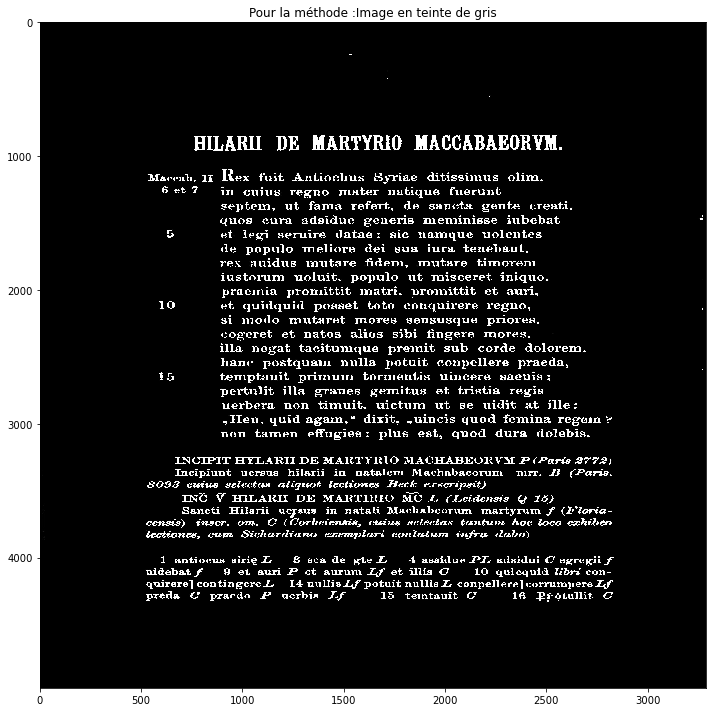

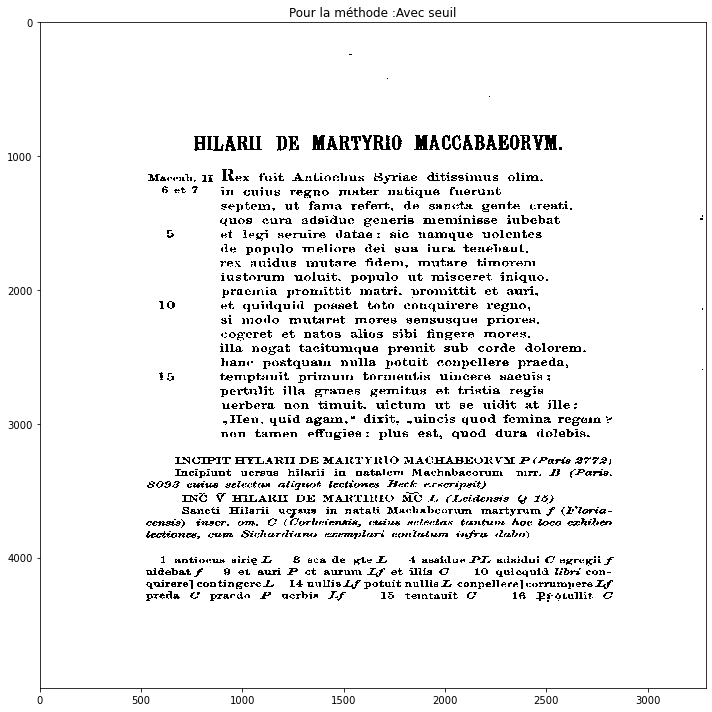

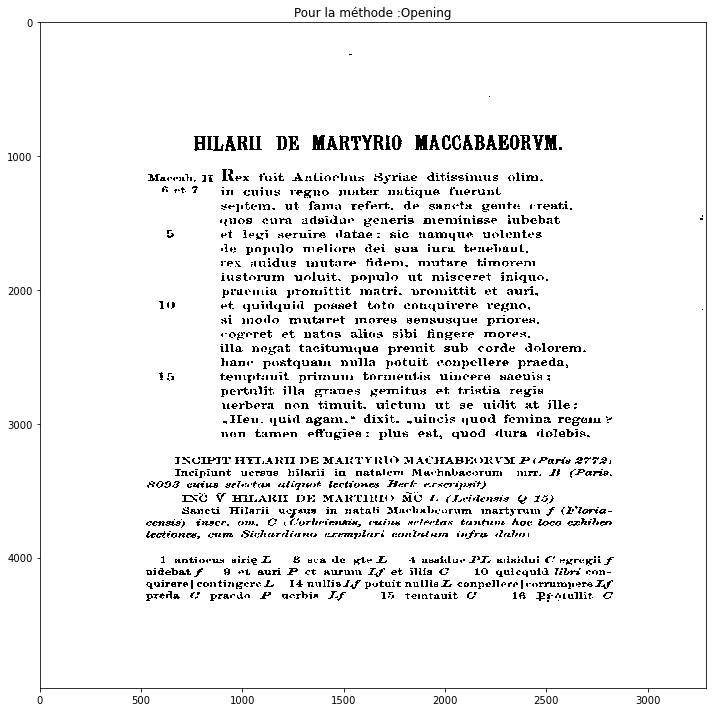

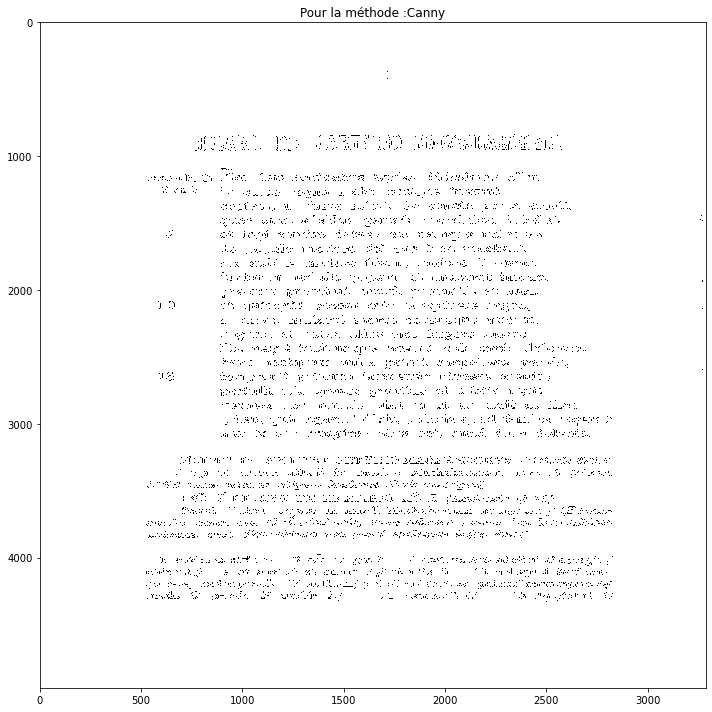

In [17]:
#On ouvre notre image brute :
img = cv2.imread('./CdMM/Photos/1.jpg')
#Gray sera notre image en teinte de gris :
gray = get_grayscale(img)
#Thresh sera notre image binarisée (FALSE = adaptatif ; TRUE = OTSU). La méthode retenue est celle d'OTSU. 
thresh = thresholding(gray,False,True)
#Dilatation + érosion :
opening = opening(thresh)
#Canny
canny = canny(thresh)
#On va afficher le résultat après chaque méthode de preprocessing :
Liste_methode=[img,gray,thresh,opening,canny]
Nom_methode=["Image brute","Image en teinte de gris", "Avec seuil", "Opening", "Canny"]
for i in range(len(Liste_methode)):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(Liste_methode[i], interpolation='nearest', aspect='auto',cmap='Greys')
    plt.title("Pour la méthode :" + Nom_methode[i])
    plt.tight_layout()

In [18]:
#On affiche le résultat de la numérisation pour chaque méthode
for i in range(len(Liste_methode)):
    print('\n')
    print("La méthode utilisée est : " + Nom_methode[i])
    print('\n')
    print(pytesseract.image_to_string(Liste_methode[i], lang='lat'))



La méthode utilisée est : Image brute


HILARII DE MARTYRIO MACCABAEORYM,

Maccab. II lex. fuit. Antiochus Syriae ditissimus olim.

6 et 7 jn cuius regno mater natique fuerunt
septem, ut fama refert, de sancta gente creati.
quos cura adsidue generis meminisse iubebat

9 et legi seruire datae: sic namque uolentes
de populo meliore dei sua iura tenebant.
rex auidus mutare fidem, mutare timorem
iustorum uoluit. populo ut misceret iniquo.
praemia promittit matri, promittit et auri,

10 et quidquid posset toto conquirere regno,
si modo mutaret mores sensusque priores,
eogeret et natos alios sibi fingere mores.
illa negat tacitumque premit sub corde dolorem.
hane postquam nulla potuit conpellere praeda,

15 temptauit primum tormentis uincere saeuis;
pertulit illa graues gemitus et tristia regis
uerbera non timuit. uictum ut se uidit at ille:
.Heu. quid agam,* dixit, ,uincis quod femina regem ?
non tamen effugies: plus est, quod dura dolebis.

INCIPIT HYLARII DE MARTYRIO MACHABEORVM P (Pari

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])
301


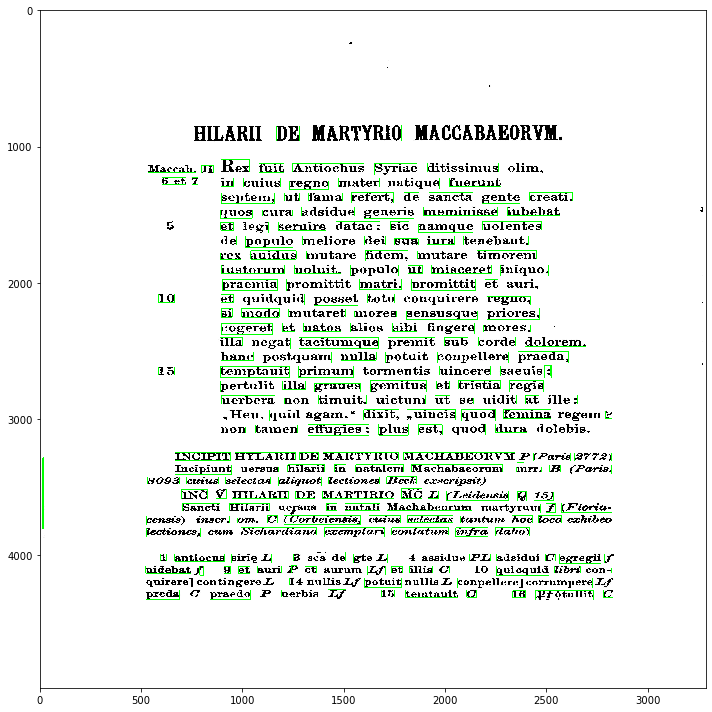

In [21]:
#On charge un dictionnaire que nécessite Pytesseract :
from pytesseract import Output
img = cv2.imread('./CdMM/Photos/1.jpg')
#On obtient une matrice caractérisant les rectangles où se trouve le texte.
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())
#On affiche l'image avec les boîtes : 
n_boxes = len(d['text'])
print(n_boxes)
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, interpolation='nearest', aspect='auto')
plt.tight_layout()

In [24]:
# Pour obtenir  un fichier ALTO XML en sortie
xml = pytesseract.image_to_alto_xml('./CdMM/Photos/1.jpg')
xml

b'<?xml version="1.0" encoding="UTF-8"?>\n<alto xmlns="http://www.loc.gov/standards/alto/ns-v3#" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.loc.gov/standards/alto/ns-v3# http://www.loc.gov/alto/v3/alto-3-0.xsd">\n\t<Description>\n\t\t<MeasurementUnit>pixel</MeasurementUnit>\n\t\t<sourceImageInformation>\n\t\t\t<fileName>C:\\Users\\KLEIN Antoine\\Desktop\\NLP Mathilde\\CdMM\\Photos\\1.jpg</fileName>\n\t\t</sourceImageInformation>\n\t\t<OCRProcessing ID="OCR_0">\n\t\t\t<ocrProcessingStep>\n\t\t\t\t<processingSoftware>\n\t\t\t\t\t<softwareName>tesseract v5.3.0.20221222</softwareName>\n\t\t\t\t</processingSoftware>\n\t\t\t</ocrProcessingStep>\n\t\t</OCRProcessing>\n\t</Description>\n\t<Layout>\n\t\t<Page WIDTH="3286" HEIGHT="4974" PHYSICAL_IMG_NR="0" ID="page_0">\n\t\t\t<PrintSpace HPOS="0" VPOS="0" WIDTH="3286" HEIGHT="4974">\n\t\t\t\t<ComposedBlock ID="cblock_0" HPOS="761" VPOS="841" WIDTH="1815" HEIGHT=

### Maintenant on va traiter les 15 photos d'un coup avec une boucle !

In [ ]:
#On charge un dictionnaire dont a besoin Pytesseract
from pytesseract import Output
import codecs
#On crée une chaîne de caractère que l'on va compléter pour chaque photo
Texte_reuni=" "
#Pour chaque photo
for i in range(1,16):
    #J'enregistre le path de la photo en question
    path="./CdMM/Photos/" + str(i) + ".jpg"
    #On ouvre notre image brute
    img = cv2.imread(path)
    #On l'affiche
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img, interpolation='nearest', aspect='auto',cmap='Greys')
    plt.tight_layout()
    plt.show()
    
    #On affiche le résultat de la numérisation pour chaque méthode.
    print('\n')
    print("La méthode utilisée est : Image Brute")
    print('\n')
    Texte_etape_i=pytesseract.image_to_string(img, lang='lat')
    print(Texte_etape_i)
    # Création d'une variable texte pour la lisibilité humaine
    Texte_reuni= Texte_reuni + " " + Texte_etape_i
    
    #On obtient une matrice qui caractérise nos rectangles dans lesquels sont contenus notre texte.
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    print(d.keys())
    #On affiche l'image avec les box.
    n_boxes = len(d['text'])
    print(n_boxes)
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)


    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img, interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.show()

# Enregistrement de ce texte nettoyé dans un nouveau fichier txt
with open('Texte_ocerise_carmen.txt', 'w') as file:
    file.write(Texte_reuni)  

In [4]:
##Ouverture : essai avec une page de manuscrit

In [ ]:
#On ouvre l'image brute.
img = cv2.imread('ciceron.png')
#Gray correspond à notre image en teintes de gris.
gray = get_grayscale(img)
#Thresh sera notre image seuillée.
thresh = thresholding(gray,False,True)
#Dilatation et binarisation :
opening = opening(thresh)
#Erosion et binarisation :
canny = canny(thresh)
#On affiche le résultat après chaque méthode de preprocessing :
Liste_methode=[img,gray,thresh,opening,canny]
Nom_methode=["Image brute","Image en teinte de gris", "Avec seuil", "Opening", "Canny"]
for i in range(len(Liste_methode)):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(Liste_methode[i], interpolation='nearest', aspect='auto',cmap='Greys')
    plt.title("Pour la méthode :" + Nom_methode[i])
    plt.tight_layout()

In [ ]:
#On affiche le résultat de la numérisation pour chaque méthode :
for i in range(len(Liste_methode)):
    print('\n')
    print("La méthode utilisée est : " + Nom_methode[i])
    print('\n')
    print(pytesseract.image_to_string(Liste_methode[i], lang='lat'))